# Fit in vision models using `quanto`


`quanto` is a library to quantize any model in int8, int4, int2 and float8 precision on GPU/CPU/MPS. In this notebook we'll see how to use quanto. If you'd like to learn more about these precisions and how inference takes place, read this [blog](https://huggingface.co/blog/merve/quantization).

Let's download the necessary libraries.

In [1]:
!pip install -U -q git+https://github.com/huggingface/transformers.git quanto accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.8 MB/s eta 0:00:00


To use quanto, we simply create and pass `QuantoConfig` object when loading a transformers model.

In [6]:
from transformers import SamModel, SamProcessor, QuantoConfig
import torch

quantization_config = QuantoConfig(weights="int8")

model = SamModel.from_pretrained("facebook/sam-vit-base", torch_dtype=torch.float32, quantization_config=quantization_config, device_map="auto")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

Some weights of SamModel were not initialized from the model checkpoint at facebook/sam-vit-base and are newly initialized: ['prompt_encoder.shared_embedding.positional_embedding']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

We can see how the `nn.Layer`s are replaced with `bnb.nn.Qlinear` layers.

In [13]:
print(model.vision_encoder.layers)

ModuleList(
  (0-11): 12 x SamVisionLayer(
    (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): SamVisionAttention(
      (qkv): QLinear(in_features=768, out_features=2304, bias=True)
      (proj): QLinear(in_features=768, out_features=768, bias=True)
    )
    (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): SamMLPBlock(
      (lin1): QLinear(in_features=768, out_features=3072, bias=True)
      (lin2): QLinear(in_features=3072, out_features=768, bias=True)
      (act): GELUActivation()
    )
  )
)


We can now make predictions. Also let's visualize the outputs of them.

In [15]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg"
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

In [19]:
input_points = [[[2592, 1728]]] # point location of the bee

inputs = processor(image, input_points=input_points, return_tensors="pt").to("cuda")
with torch.no_grad():
    outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

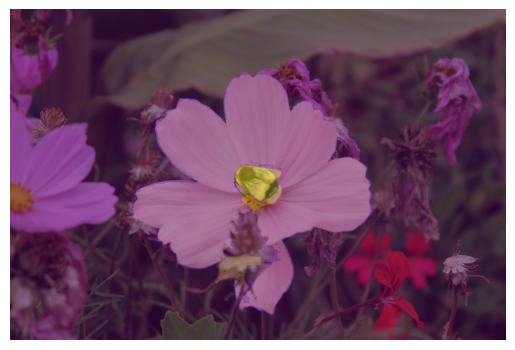

In [26]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')

for i, mask in enumerate(masks[0][0]):
    plt.imshow(mask, cmap='viridis', alpha=0.2, vmin=0, vmax=1)

plt.axis('off')
plt.show()

Let's try larger models. We can do 8-bit inference on a VLM of 7B params.

We can use the same quantization config.

In [28]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch

model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

processor = LlavaNextProcessor.from_pretrained(model_id)

model = LlavaNextForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float32, quantization_config=quantization_config, device_map="auto")

preprocessor_config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

We can infer as usual.

In [30]:
prompt = "[INST] <image>\nWhat is shown in this image? [/INST]"

inputs = processor(prompt, image, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_new_tokens=100)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [33]:
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt)-1:])

image shows a close-up of a flowering plant with several flowers in bloom. The flowers are pink with a darker pink or purple center, and one of them has a bee perched on it. The bee appears to be a bumblebee, which is a type of bee known for its large size and fuzzy body. The plant is surrounded by other plants with various colors of flowers, including red and white, suggesting a diverse and colorful garden or


Let's fit an even bigger model. Note that the inference will take a long long time compared to running this model in CUDA native precision in A100 (as one should). This is because 8-bit is not native to NVIDIA hardware: we loaded the model to float16, and the model is quantized and dequantized back and forth to 2-bit, which adds overhead. Moreover, T4 is not as fast as well.

In [39]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch

model_id = "llava-hf/llava-v1.6-34b-hf"
quantization_config = QuantoConfig(weights="int8")

processor = LlavaNextProcessor.from_pretrained(model_id)

model = LlavaNextForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16,
                                                          quantization_config=quantization_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
prompt = "<|im_start|>system\nAnswer the questions.<|im_end|><|im_start|>user\n<image>\nWhat is shown in this image?<|im_end|><|im_start|>assistant\n"

inputs = processor(prompt, image, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_new_tokens=100)

In [ ]:
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])